# 使用Notebook进行交互式智能化数据分析与可视化数据清洗
1. 构建样本数据，使用Serverless Spark引擎将数据写入到Paimon表中
2. 使用widget进行交互式数据查询
3. 多引擎数据查询（Spark、StarRocks、Hologres、MaxCompute）
4. 使用DataWorks Copilot进行SQL生成，并使用StarRocks和Hologres进行数据查询
5. 使用Data Wrangler进行数据可视化清洗

## 1. 构建数据
使用Serverless Spark，创建一张名为user_info的Paimon表。

In [7]:
use openlake_win.default;
create table if not exists user_info
(
    userid bigint,
    name string,
    age int,
    addr string,
    level int,
    is_vip int,
    order_num int,
    order_fee float
)

随机生成100条测试数据。

In [ ]:
import random
import string

# 省份和城市数据
provinces_cities = {
    "浙江": ["杭州", "宁波", "温州"],
    "广东": ["广州", "深圳", "佛山"],
    "江苏": ["南京", "无锡", "苏州"],
    "山东": ["济南", "青岛", "烟台"],
    "四川": ["成都", "绵阳", "德阳"],
}

def random_name():
    return ''.join(random.choices(string.ascii_lowercase, k=random.randint(3, 10)))

def random_addr():
    province = random.choice(list(provinces_cities.keys()))
    city = random.choice(provinces_cities[province])
    return f"{province}, {city}"

def random_level():
    return random.choice([1, 2, 3, "NULL" if random.random() < 0.2 else random.choice([1, 2, 3])])  # 20%概率为NULL

# 生成数据并输出 SQL 语句
insert_statements = []
for userid in range(1, 101):
    name = random_name()
    age = random.randint(18, 70)  # 假设年龄范围为18到70
    addr = random_addr()
    level = random_level()
    is_vip = random.randint(0, 1)  # 假设0或1
    order_num = random.randint(0, 100)  # 假设订单数量
    order_fee = round(random.uniform(0, 1000), 2)  # 假设订单费用范围为0到1000

    insert_statement = f"INSERT INTO user_info (userid, name, age, addr, level, is_vip, order_num, order_fee) VALUES ({userid}, '{name}', {age}, '{addr}', {level}, {is_vip}, {order_num}, {order_fee});"
    insert_statements.append(insert_statement)

insert_data_sql = "\n".join(insert_statements)
print(insert_data_sql)

执行生成的Insert语句，插入测试数据到Paimon表中。

In [9]:
{insert_data_sql}

## 2. 交互式数据查询

使用Widgets，通过Python代码生成简单的UI组件，作为交互式数据查询的查询条件选择器。

对标Snowflake的Streamlit功能。

In [3]:
from ipywidgets import interact, widgets
from IPython.display import display

# 定义变量，可以在SQL中引用
query_age_min = 1
query_age_max = 80
query_province = "浙江"
query_is_vip = 0

print("用户信息查询条件：")
# 年龄范围选择器
range_slider = widgets.IntRangeSlider(
    value=[20, 60], 
    min=1, 
    max=100,
    step=1,
    description='年龄范围：',
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
display(range_slider)
def update_range(change):
    global query_age_min
    global query_age_max
    query_age_min = change["new"][0]
    query_age_max = change["new"][1]
range_slider.observe(update_range, names='value')

# 所在省份Dropdown
options = ['浙江', '江苏', '四川', '山东', '广东']
province_dropdown = widgets.Dropdown(
    options=options,
    description='所在省份：',
    value='浙江'
)
display(province_dropdown)
def on_province_change(change):
    global query_province
    query_province = change["new"]
province_dropdown.observe(on_province_change, names='value')

# 是否是VIP CheckBox
checkbox = widgets.Checkbox(
    value=False,
    description='是否VIP',
)
def on_checkbox_change(change):
    global query_is_vip
    query_is_vip = int(change["new"])
checkbox.observe(on_checkbox_change, names='value')
display(checkbox)


用户信息查询条件：


IntRangeSlider(value=(20, 60), description='年龄范围：', min=1)

Dropdown(description='所在省份：', options=('浙江', '江苏', '四川', '山东', '广东'), value='浙江')

Checkbox(value=False, description='是否VIP')

交互式数据查询

在SQL中引用Python中的变量值，在上面的UI组件中设置值，下方的SQL可以实时获得变量的值。

In [44]:
select
    * 
from 
    openlake_win.default.user_info
where 
    age >= {query_age_min} and age <= {query_age_max}
    and addr like "{query_province}%"
    and is_vip = {query_is_vip}

userid      name age    addr level is_vip order_num order_fee
0     87      taco  38  四川, 德阳     3      0        59    347.14
1     86  wkjkxzrj  62  四川, 德阳     1      0        52    902.19
2     92     owxlu  68  四川, 德阳     1      0        24    669.52
3     12      xrni  65  四川, 德阳     3      0        96    561.47
4     68    yduwbg  70  四川, 绵阳     1      0        38    880.97

[5 rows x 8 columns]

## 3. 多种引擎查询OpenLakeHouse中的Paimon表

### 使用Spark SQL查询Paimon表

In [46]:
select 
    level as user_level,
    sum(order_num) as order_num_total
from
    openlake_win.`default`.user_info
where
    level is not NULL
GROUP BY user_level;

user_level order_num_total
0          1            1035
1          3            2160
2          2            1731

[3 rows x 2 columns]

### 使用StarRocks SQL查询Paimon表

通过StarRocks的External Catalog映射到DLF Catalog

In [47]:
select 
    level as user_level,
    sum(order_num) as order_num_total
from
    openlake_win.`default`.user_info
where
    level is not NULL
GROUP BY user_level;

user_level  order_num_total
0           1             1035
1           3             2160
2           2             1731

[3 rows x 2 columns]

### 使用Hologres SQL查询Paimon表

通过Hologres的External Database映射到DLF Catalog

In [48]:
select 
    level as user_level,
    sum(order_num) as order_num_total
from
    openlake_win.default.user_info
where
    level is not NULL
GROUP BY user_level;

user_level  order_num_total
0           2             1731
1           3             2160
2           1             1035

[3 rows x 2 columns]

### 使用MaxCompute SQL查询Paimon表

通过MaxCompute的External Project映射到DLF Catalog

使用MaxFrame DataFrame执行

In [49]:
set odps.task.major.version=flighting;
set odps.namespace.schema=true;
set odps.sql.allow.namespace.schema=true;
set odps.sql.dlf.work.around.oss.endpoint=oss-cn-hangzhou-internal.aliyuncs.com;

select 
    level as user_level,
    sum(order_num) as order_num_total
from
    openlake_win.default.user_info
where
    level is not NULL
GROUP BY user_level;

[Warnning] Can not use maxframe with set statement, will use pyodps to execute this statement.
MaxCompute LogView Address: http://logview.alibaba-inc.com/logview/?h=http://service.cn-shanghai.maxcompute.aliyun-inc.com/daily&p=openlake_win&i=20240815062729145gq330lrdd29&token=NjAvTWJNSzNzaWVnUmdtOE5UY0YzRitXRElJPSxPRFBTX09CTzoxNDg2NDIwNDEwNzUwNzMyLDE3MjYyOTUyOTQseyJTdGF0ZW1lbnQiOlt7IkFjdGlvbiI6WyJvZHBzOlJlYWQiXSwiRWZmZWN0IjoiQWxsb3ciLCJSZXNvdXJjZSI6WyJhY3M6b2RwczoqOnByb2plY3RzL29wZW5sYWtlX3dpbi9pbnN0YW5jZXMvMjAyNDA4MTUwNjI3MjkxNDVncTMzMGxyZGQyOSJdfV0sIlZlcnNpb24iOiIxIn0=



user_level  order_num_total
0           1             1035
1           2             1731
2           3             2160

[3 rows x 2 columns]

## 4. DataWorks Copilot：智能SQL生成

统计不同用户等级的订单数量总和

In [42]:
select 
    level as user_level,
    sum(order_num) as order_num_total
from
    openlake_win.`default`.user_info
where
    level is not NULL
GROUP BY user_level;

user_level  order_num_total
0           2             1731
1           1             1035
2           3             2160

[3 rows x 2 columns]

使用DataWorks Copilot进行SQL生成和改写，这里演示将上面的SQL的输出结果行转列。

prompt: 将此SQL的输出结果从行转置为行，user_level的取值为1，2，3

In [45]:
SELECT 
    SUM(CASE WHEN level = 1 THEN order_num ELSE 0 END) AS level_1_order_num,
    SUM(CASE WHEN level = 2 THEN order_num ELSE 0 END) AS level_2_order_num,
    SUM(CASE WHEN level = 3 THEN order_num ELSE 0 END) AS level_3_order_num
FROM 
    openlake_win.default.user_info
WHERE 
    level IS NOT NULL;


level_1_order_num  level_2_order_num  level_3_order_num
0               1035               1731               2160

[1 rows x 3 columns]

In [69]:
SELECT 
  SUM(CASE WHEN level = 1 THEN order_num ELSE 0 END) AS level_1_order_num,
  SUM(CASE WHEN level = 2 THEN order_num ELSE 0 END) AS level_2_order_num,
  SUM(CASE WHEN level = 3 THEN order_num ELSE 0 END) AS level_3_order_num
FROM openlake_win.default.user_info
WHERE level IS NOT NULL;


level_1_order_num  level_2_order_num  level_3_order_num
0               1035               1731               2160

[1 rows x 3 columns]

## 5. 可视化数据清洗与数据展示

使用Spark SQL查询原始数据

In [1]:
select * from openlake_win.default.user_info;

userid        name age    addr level is_vip order_num order_fee
0       1      znbcew  18  四川, 成都     3      1        90    309.91
1       2      vgpsps  43  浙江, 温州     2      0        97      54.5
2       3  cwckakunzb  62  四川, 成都     2      1        93    367.12
3       4   azxjzipgg  31  广东, 广州     2      1        81     272.5
4       5  rvssqmqrmt  62  山东, 青岛     2      1        20    729.74
..    ...         ...  ..     ...   ...    ...       ...       ...
95     24       sinxo  52  江苏, 南京     3      0        92      34.3
96     25      vzmfhz  34  广东, 佛山     1      1        63    614.36
97     26      aoocui  53  广东, 深圳     3      1        76    398.56
98     27        whxd  49  广东, 广州  None      0        26    881.76
99     28        licq  56  山东, 济南     1      1        55    141.01

[100 rows x 8 columns]

得益于新版数据开发IDE是基于VS Code底座构建的，因此我们可以使用VS Code丰富的插件。

下面使用Data Wrangler插件，进行可视化数据准备与清洗，并生成python代码。

上面SQL查询的结果保存到一个名为df_user_info的DataFrame对象中，在Data Wranger中可以直接打开df_user_info。

In [50]:
df_user_info

userid        name age    addr level is_vip order_num order_fee
0       1      znbcew  18  四川, 成都     3      1        90    309.91
1       2      vgpsps  43  浙江, 温州     2      0        97      54.5
2       3  cwckakunzb  62  四川, 成都     2      1        93    367.12
3       4   azxjzipgg  31  广东, 广州     2      1        81     272.5
4       5  rvssqmqrmt  62  山东, 青岛     2      1        20    729.74
..    ...         ...  ..     ...   ...    ...       ...       ...
95     96   zmzozafjc  46  广东, 广州     3      0        38    395.27
96     97         jnr  19  江苏, 苏州     3      1        22    860.57
97     98    ijgfwrda  60  广东, 深圳     3      0        51     56.45
98     99  zyjefoqcyz  61  山东, 济南     3      0        30      1.91
99    100    sfjrptyt  65  广东, 深圳     2      0        67     91.04

[100 rows x 8 columns]

In [52]:
"""
Data Wrangler 生成的单元格。
"""
import pandas as pd

def clean_data(df_user_info):
    # 将缺少的值替换为列: 'level' 中的 "1"
    df_user_info = df_user_info.fillna({'level': "1"})
    # 在列中使用字符串“,”拆分文本: 'addr'
    loc_0 = df_user_info.columns.get_loc('addr')
    df_user_info_split = df_user_info['addr'].str.split(pat=',', expand=True).add_prefix('addr_')
    df_user_info = pd.concat([df_user_info.iloc[:, :loc_0], df_user_info_split, df_user_info.iloc[:, loc_0:]], axis=1)
    df_user_info = df_user_info.drop(columns=['addr'])
    # 将列 'addr_0' 重命名为 'province'
    df_user_info = df_user_info.rename(columns={'addr_0': 'province'})
    # 将列 'addr_1' 重命名为 'city'
    df_user_info = df_user_info.rename(columns={'addr_1': 'city'})
    return df_user_info

df_user_info_clean = clean_data(df_user_info.copy())
df_user_info_clean.head(100)

userid        name age province city level is_vip order_num order_fee
0       1      znbcew  18       四川   成都     3      1        90    309.91
1       2      vgpsps  43       浙江   温州     2      0        97      54.5
2       3  cwckakunzb  62       四川   成都     2      1        93    367.12
3       4   azxjzipgg  31       广东   广州     2      1        81     272.5
4       5  rvssqmqrmt  62       山东   青岛     2      1        20    729.74
..    ...         ...  ..      ...  ...   ...    ...       ...       ...
95     96   zmzozafjc  46       广东   广州     3      0        38    395.27
96     97         jnr  19       江苏   苏州     3      1        22    860.57
97     98    ijgfwrda  60       广东   深圳     3      0        51     56.45
98     99  zyjefoqcyz  61       山东   济南     3      0        30      1.91
99    100    sfjrptyt  65       广东   深圳     2      0        67     91.04

[100 rows x 9 columns]

In [27]:
"""
Data Wrangler 生成的单元格。
"""
import pandas as pd

def clean_data(df_user_info):
    # 将缺少的值替换为列: 'level' 中的 "1"
    df_user_info = df_user_info.fillna({'level': "1"})
    # 在列中使用字符串“,”拆分文本: 'addr'
    loc_0 = df_user_info.columns.get_loc('addr')
    df_user_info_split = df_user_info['addr'].str.split(pat=',', expand=True).add_prefix('addr_')
    df_user_info = pd.concat([df_user_info.iloc[:, :loc_0], df_user_info_split, df_user_info.iloc[:, loc_0:]], axis=1)
    df_user_info = df_user_info.drop(columns=['addr'])
    # 将列 'addr_0' 重命名为 'province'
    df_user_info = df_user_info.rename(columns={'addr_0': 'province'})
    # 将列 'addr_1' 重命名为 'city'
    df_user_info = df_user_info.rename(columns={'addr_1': 'city'})
    # 将列中的第一个字符大写: 'name'
    df_user_info['name'] = df_user_info['name'].str.capitalize()
    # 将列: 'order_num' 的列类型更改为 int16
    df_user_info = df_user_info.astype({'order_num': 'int16'})
    # 将列: 'order_fee' 的列类型更改为 float16
    df_user_info = df_user_info.astype({'order_fee': 'float16'})
    return df_user_info

df_user_info_clean = clean_data(df_user_info.copy())
df_user_info_clean.head(100)

userid        name age province city level is_vip  order_num   order_fee
0       1      Znbcew  18       四川   成都     3      1         90  310.000000
1       2      Vgpsps  43       浙江   温州     2      0         97   54.500000
2       3  Cwckakunzb  62       四川   成都     2      1         93  367.000000
3       4   Azxjzipgg  31       广东   广州     2      1         81  272.500000
4       5  Rvssqmqrmt  62       山东   青岛     2      1         20  729.500000
..    ...         ...  ..      ...  ...   ...    ...        ...         ...
95     96   Zmzozafjc  46       广东   广州     3      0         38  395.250000
96     97         Jnr  19       江苏   苏州     3      1         22  860.500000
97     98    Ijgfwrda  60       广东   深圳     3      0         51   56.437500
98     99  Zyjefoqcyz  61       山东   济南     3      0         30    1.910156
99    100    Sfjrptyt  65       广东   深圳     2      0         67   91.062500

[100 rows x 9 columns]

使用matplotlib绘制图表

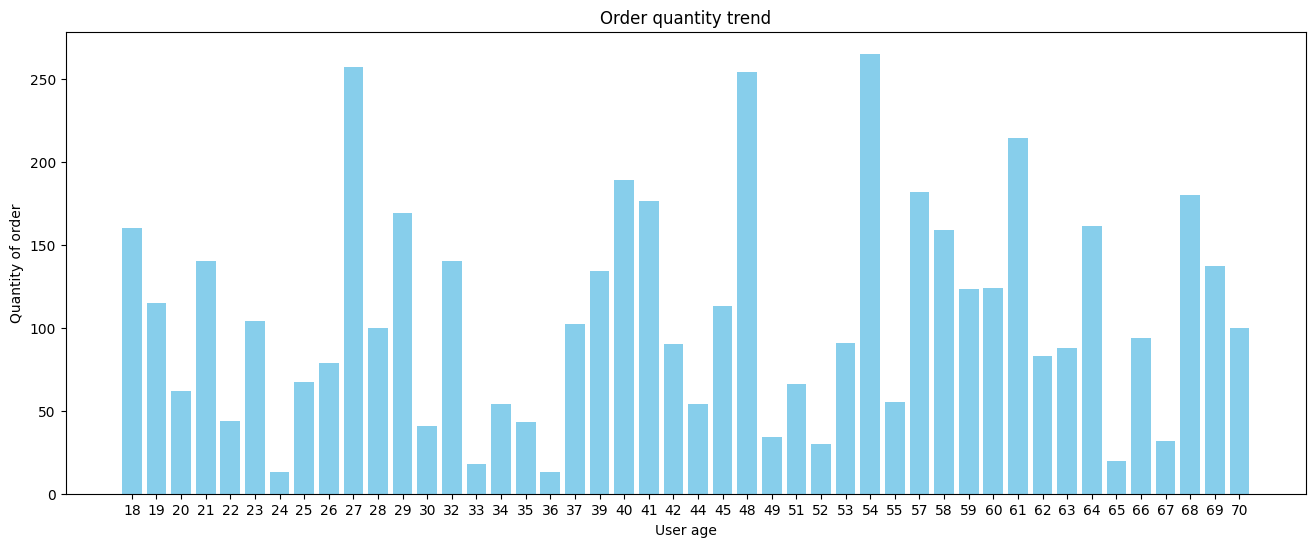

In [63]:
import matplotlib.pyplot as plt

df_user_info_clean['order_num'] = df_user_info_clean['order_num'].astype(int)
city_order_num = df_user_info_clean.groupby('age')['order_num'].sum().reset_index()

plt.figure(figsize=(16, 6))
plt.bar(city_order_num['age'], city_order_num['order_num'], color='skyblue')
plt.title('Order quantity trend')
plt.xlabel('User age')
plt.ylabel('Quantity of order')
plt.show()